In [1]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
import json
# import plotly.graph_objects as go
import plotly.express as px

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
# import spacy

import time
import string


# from sklearn.

# MODELS
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

# EVALUATION METRICS and TOOLS
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import classification_report


# OTHER TOOLS
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import  HalvingGridSearchCV, RepeatedStratifiedKFold, cross_val_score, train_test_split

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from utils import main as utils, plots, preprocessing


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\alhas\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Needed functions

In [2]:

with open("data/id_to_label.json", "r") as f:
    # Write the dictionary to the file in JSON format
    id_to_label = json.load(f)

In [3]:
def plot_feature_effects(clf, 
                         X_train,
                         feature_names,
                         target_names,
                         to_labels=False,
                         top_k=5,
                         verbose=False):
    # learned coefficients weighted by frequency of appearance
    average_feature_effects = clf.coef_ * np.asarray(X_train.mean(axis=0)).ravel()

    target_names = np.sort(target_names)
    if to_labels:
        target_names = [id_to_label[i] for i in target_names]
        
    fig, ax = plt.subplots(figsize=(10, 8))

    # Get top k features for each target class
    for i, label in enumerate(target_names):
        # if len(average_feature_effects) > 1:
        #     print(i, 'label', label, average_feature_effects)
        top_indices = np.argsort(average_feature_effects[i if len(average_feature_effects) > 1 else 0])[::-1][:top_k]
        top_k_words = feature_names[top_indices]
        top_k_effects = average_feature_effects[i if len(average_feature_effects) > 1 else 0, top_indices]
        ax.barh(top_k_words, top_k_effects, label=label, alpha=0.5)

    ax.set_xlabel('Average Feature Effects')
    ax.legend()
    ax.set_title(f'Top {top_k} Feature Effects per Target Class')

    if verbose:
        # Display top k keywords for each class in a table
        top_k_keywords = pd.DataFrame()
        for i, label in enumerate(target_names):
            top_indices = np.argsort(average_feature_effects[i if len(average_feature_effects) > 1 else 0])[::-1][:top_k]
            top_k_words = feature_names[top_indices]
            top_k_keywords[label] = top_k_words
        print(f"Top {top_k} Keywords per Class:\n{top_k_keywords}")
    plt.show()
    return ax

In [4]:
# def plot_feature_effects(clf, X_train, feature_names, target_names, top_n=5):
#     # learned coefficients weighted by frequency of appearance
#     average_feature_effects = clf.coef_ * np.asarray(X_train.mean(axis=0)).ravel()

#     # find top n keywords for each label
#     top_keywords = {}
#     for i, label in enumerate(target_names):
#         top_n_indices = np.argsort(average_feature_effects[i])[::-1][:top_n]
#         top_keywords[label] = [(feature_names[idx], round(average_feature_effects[i, idx], 3)) for idx in top_n_indices]

#     # create a horizontal bar chart for each label
#     fig, axs = plt.subplots(nrows=len(target_names), figsize=(12, 8))
#     for i, label in enumerate(target_names):
#         keywords, importance = zip(*top_keywords[label])
#         axs[i].barh(keywords, importance, color='tab:blue')
#         axs[i].set_xlim(left=-1, right=1)
#         axs[i].set_xlabel('Feature Importance')
#         axs[i].set_title(f'Top {top_n} keywords for {label}')

#     plt.tight_layout()
#     plt.show()


In [5]:
def train_model(model, 
                categories=None, 
                cat=None,
                exact=None,
                verbose=False):

    if verbose:
        print("#"*10, "Loading data..")
        print(exact, cat, categories)
    df, X_train, X_test, y_train, y_test, feature_names, target_names = utils.load_dataset('data/en_data.csv',
                                                                                           target_label='ocms',
                                                                                           specific_cat=cat,
                                                                                           chosen_categories=categories,
                                                                                           exact=cat and exact,
                                                                                           # sample=5000,
                                                                                           verbose=verbose)
    if verbose:
        print("#"*10, f"Training {model.__class__.__name__}\n")
    
    model.fit(X_train, y_train)

    if verbose:
        if cat:
            # fig = px.bar(x=[id_to_label[i] for i in df['ocms']], color='#EB89B5')
            # fig.show()
            # f = go.Figure()
            # # f.add_histogram(df['ocms'])
            # f.add_bar([id_to_label[i] for i in df['ocms']])
            # f.show()
            sns.histplot([f'{id_to_label[i]} ({i})' for i in df['ocms']])
            plt.xticks(rotation=90)
            plt.show()
            
        print("#"*10, model.score(X_test, y_test))
    
    pred = model.predict(X_test)
    return df, X_train, pred, y_test, feature_names, target_names

In [6]:
def run(models=['LR', 'RF', 'KN'], **kwargs):
    # for cat in categories:
# for cat in [224, 226]:
    # print(cat)
    for model in models:
        print('#'*10, cat, model, '\n')
        if model == 'RF':
            clf = RandomForestClassifier(n_estimators=100)
        # pipe = make_pipeline(StandardScaler(with_mean=False), LogisticRegression(max_iter=10000))  
        elif model == 'LR':
            clf = LogisticRegression(max_iter=10000)
        elif model == 'KN':
            clf = make_pipeline(StandardScaler(with_mean=False),
                 KNeighborsClassifier(n_neighbors=16))
        if kwargs.get('cat'):
            df, X_train, pred, y_test, fn, tn = train_model(clf, verbose=True, **kwargs)
        else:
            df, X_train, pred, y_test, fn, tn = train_model(clf, exact=False, verbose=True, **kwargs)
            # df, X_train, pred, y_test, fn, tn = train_model(clf, cat=None, verbose=True)

        plots.make_cm(clf, pred, y_test, tn, to_labels=id_to_label)
        if model == 'RF':
            # plots.plot_feature_effects(clf, X_train, fn, tn)  
            plots.plot_feature_importance(clf.feature_importances_, fn, 'RF')    
        else:
            plot_feature_effects(clf, X_train, fn, tn, to_labels=id_to_label)#, top_k=10)    

# Specific categories

########## None LR 

########## Loading data..
False None [224, 226, 241, 243]


C:\Users\alhas\anaconda3\envs\nlp\lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


10793 documents - 4.70MB (training set)
4 categories
vectorize training done in 2.606s at 1.804MB/s
n_samples: 8634, n_features: 7889
n_samples: 2159, n_features: 7889
########## Training LogisticRegression

########## 0.8698471514590088


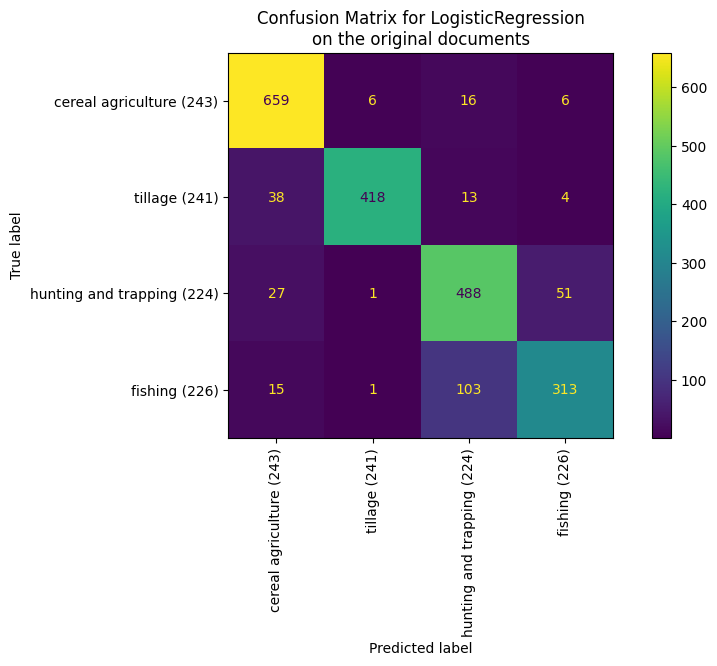

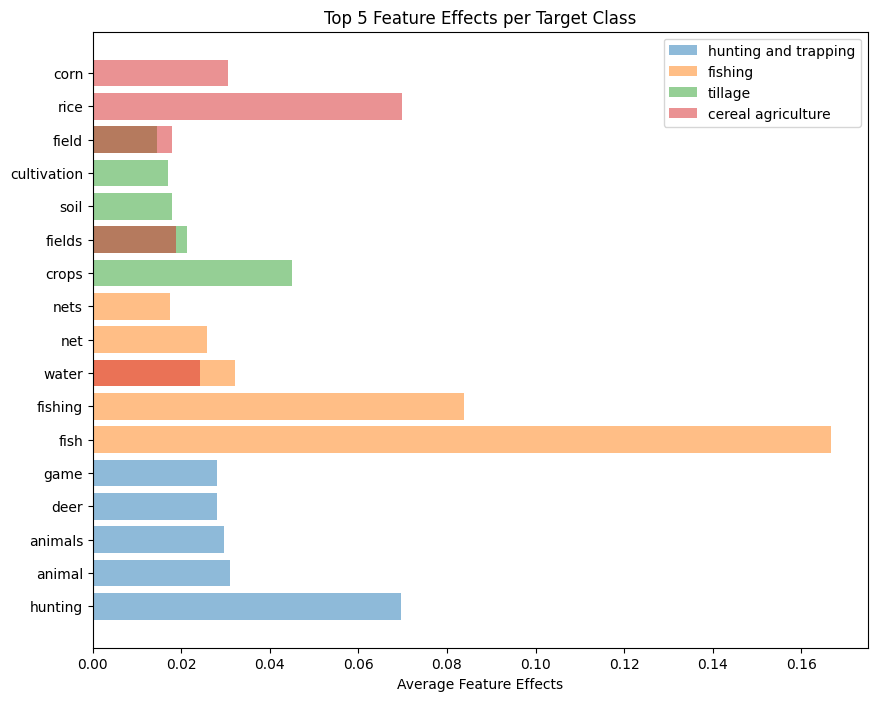

########## None RF 

########## Loading data..
False None [224, 226, 241, 243]


C:\Users\alhas\anaconda3\envs\nlp\lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


10793 documents - 4.70MB (training set)
4 categories
vectorize training done in 2.621s at 1.793MB/s
n_samples: 8634, n_features: 7889
n_samples: 2159, n_features: 7889
########## Training RandomForestClassifier



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


########## 0.8388142658638258


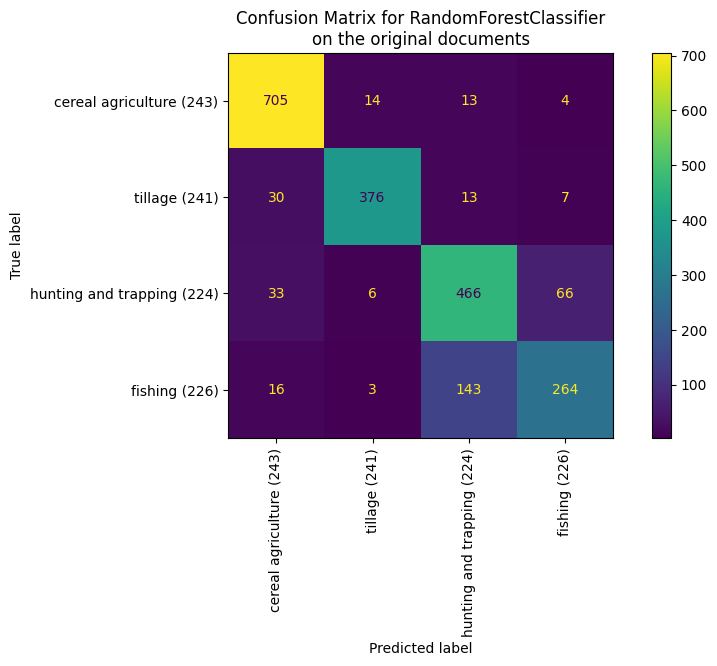

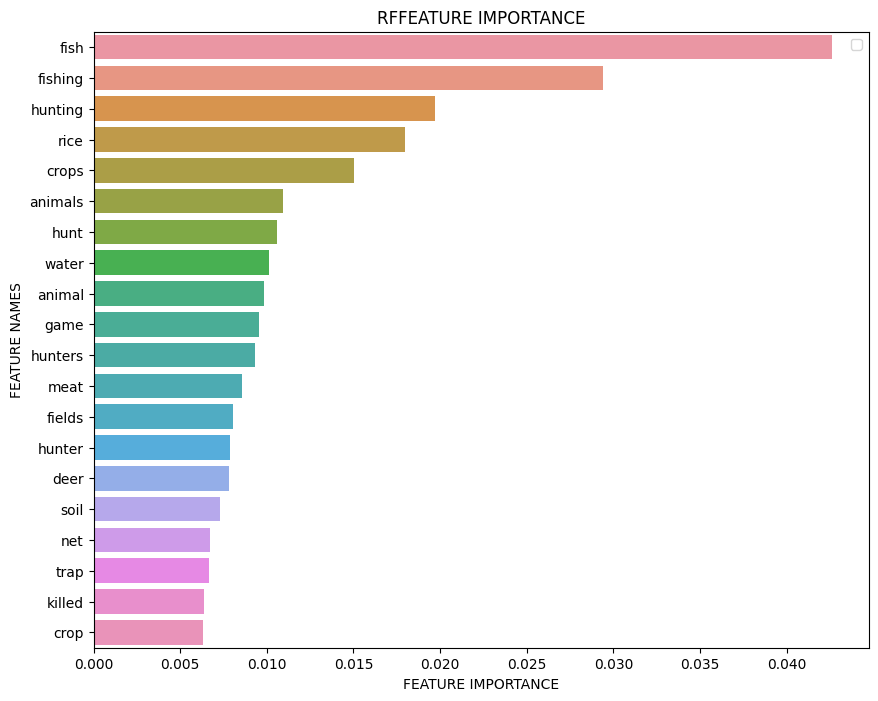

In [7]:
run(models=['LR', 'RF'], categories=[224, 226, 241, 243])

# Cat vs subcategories (binary classification)

########## 224 LR 

########## Loading data..
True 224 None


C:\Users\alhas\anaconda3\envs\nlp\lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


8717 documents - 3.86MB (training set)
2 categories
vectorize training done in 2.158s at 1.788MB/s
n_samples: 6973, n_features: 6825
n_samples: 1744, n_features: 6825
########## Training LogisticRegression



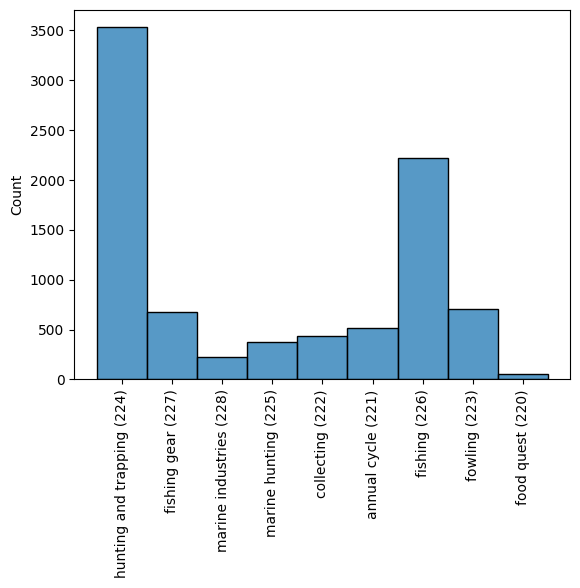

########## 0.9053899082568807


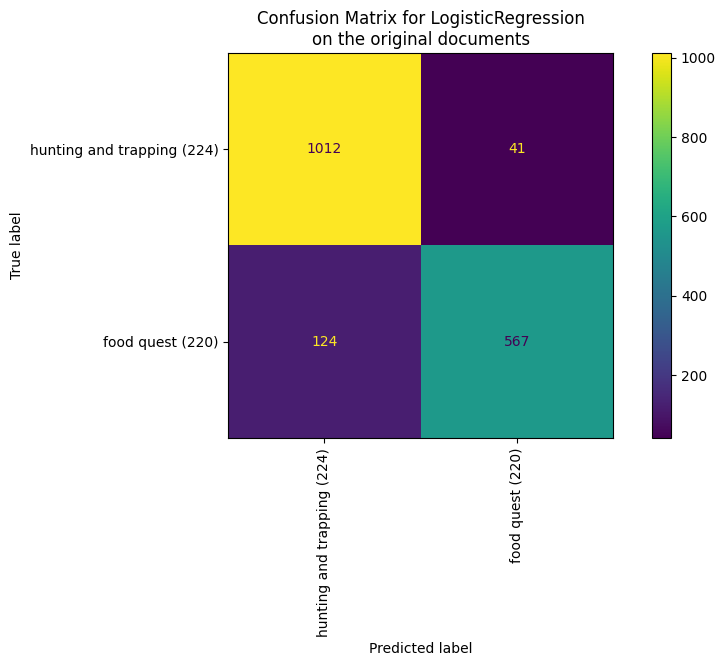

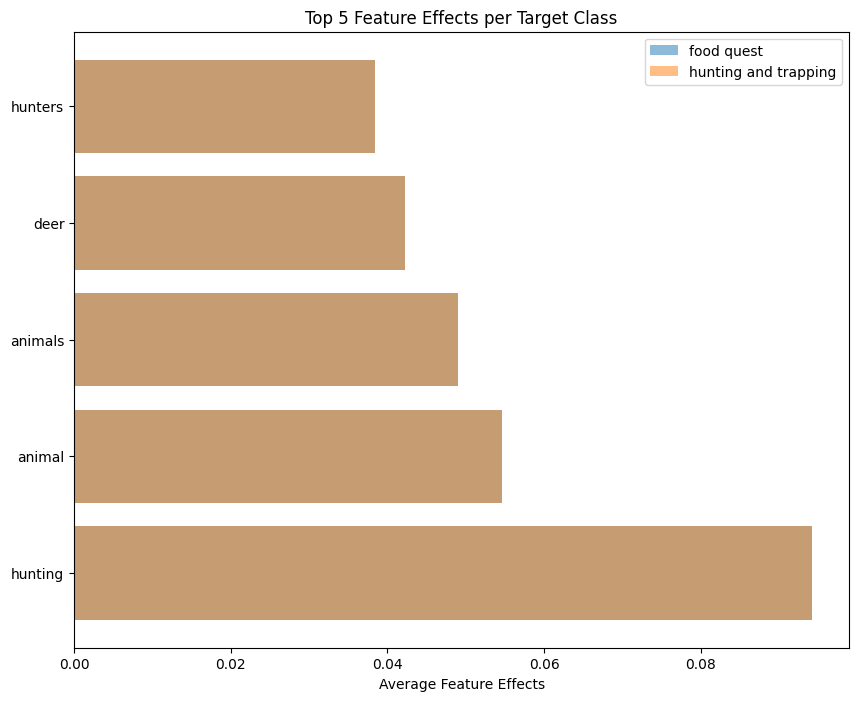

########## 224 RF 

########## Loading data..
True 224 None


C:\Users\alhas\anaconda3\envs\nlp\lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


8717 documents - 3.86MB (training set)
2 categories
vectorize training done in 2.192s at 1.761MB/s
n_samples: 6973, n_features: 6825
n_samples: 1744, n_features: 6825
########## Training RandomForestClassifier



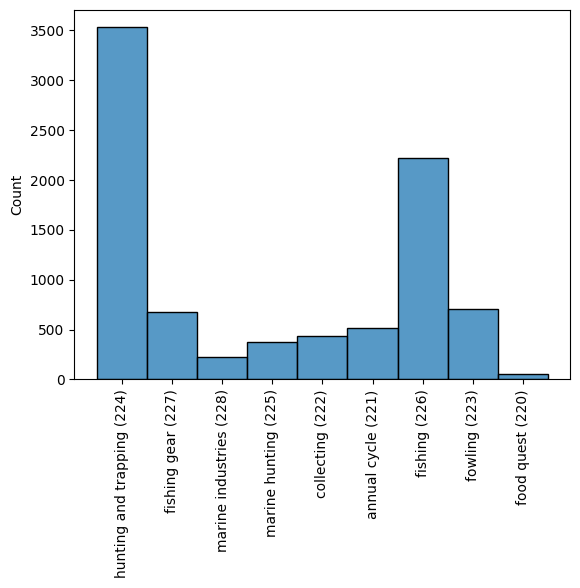

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


########## 0.8944954128440367


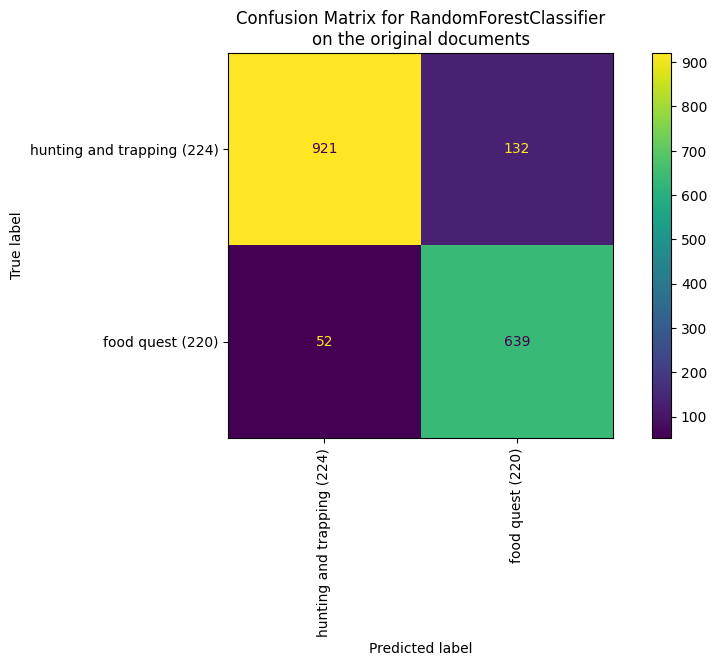

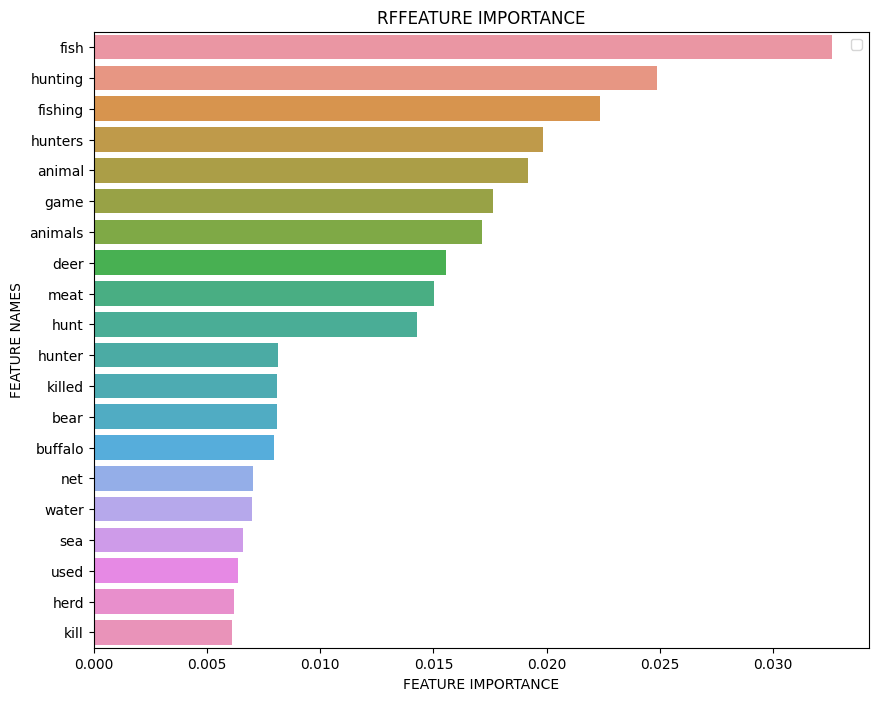

########## 226 LR 

########## Loading data..
True 226 None


C:\Users\alhas\anaconda3\envs\nlp\lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


8717 documents - 3.86MB (training set)
2 categories
vectorize training done in 2.176s at 1.773MB/s
n_samples: 6973, n_features: 6825
n_samples: 1744, n_features: 6825
########## Training LogisticRegression



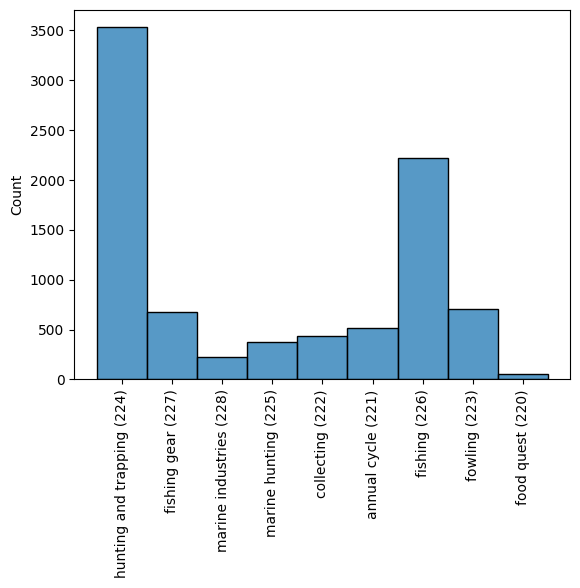

########## 0.8784403669724771


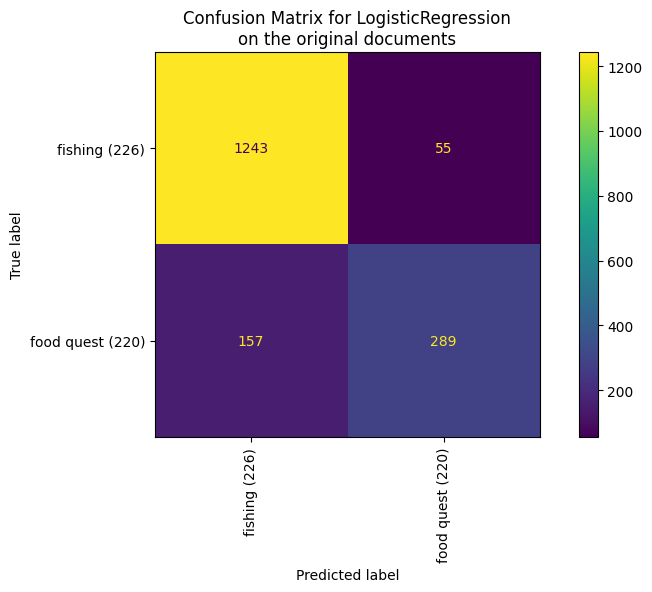

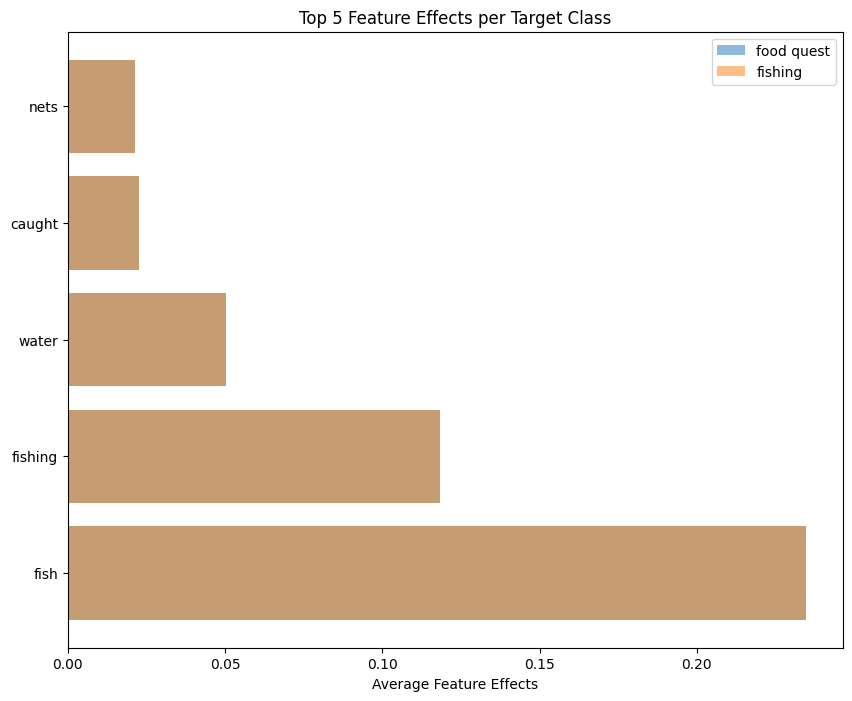

########## 226 RF 

########## Loading data..
True 226 None


C:\Users\alhas\anaconda3\envs\nlp\lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


8717 documents - 3.86MB (training set)
2 categories
vectorize training done in 2.173s at 1.776MB/s
n_samples: 6973, n_features: 6825
n_samples: 1744, n_features: 6825
########## Training RandomForestClassifier



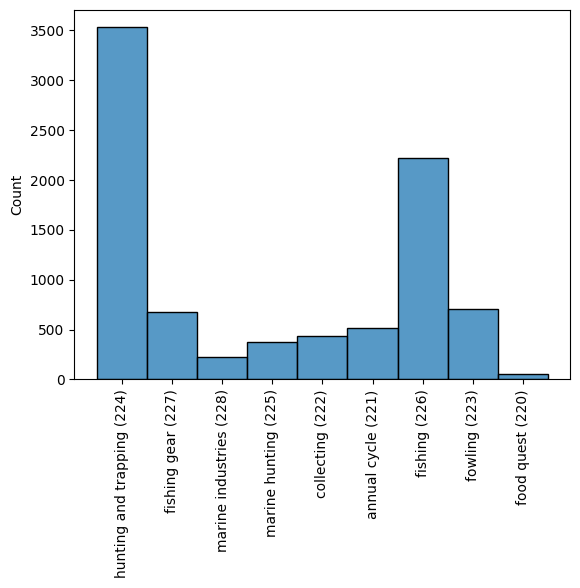

########## 0.8916284403669725


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


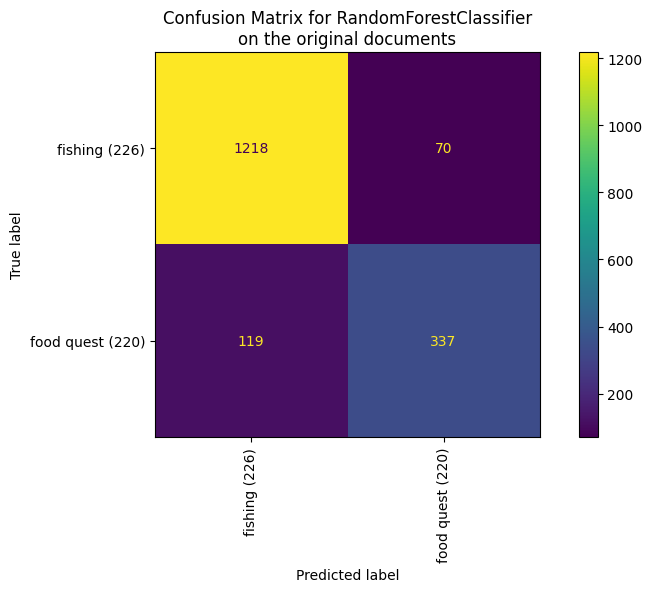

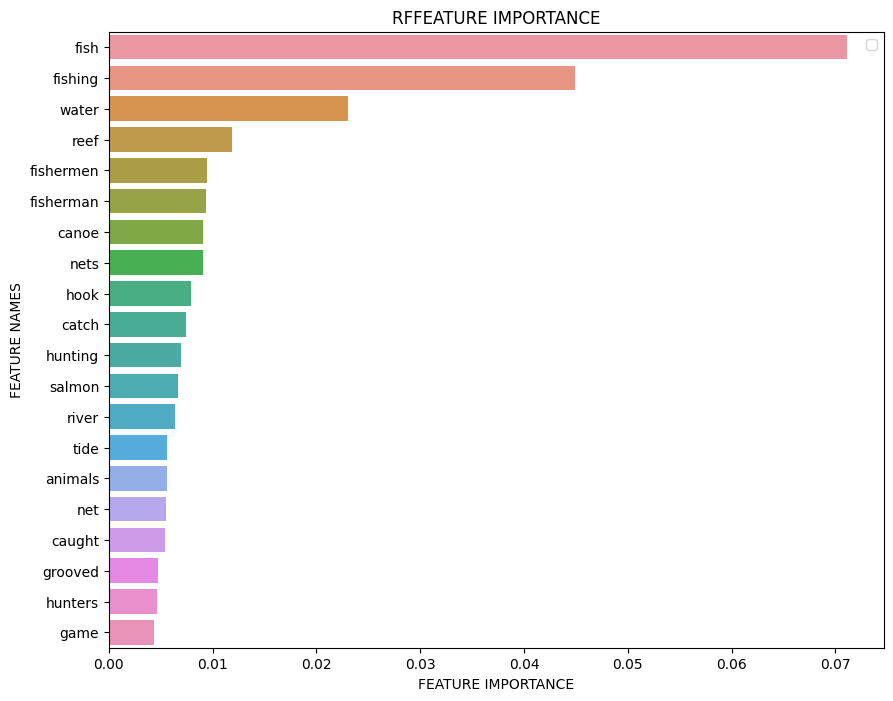

########## 241 LR 

########## Loading data..
True 241 None


C:\Users\alhas\anaconda3\envs\nlp\lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


8183 documents - 3.58MB (training set)
2 categories
vectorize training done in 1.970s at 1.816MB/s
n_samples: 6546, n_features: 6404
n_samples: 1637, n_features: 6404
########## Training LogisticRegression



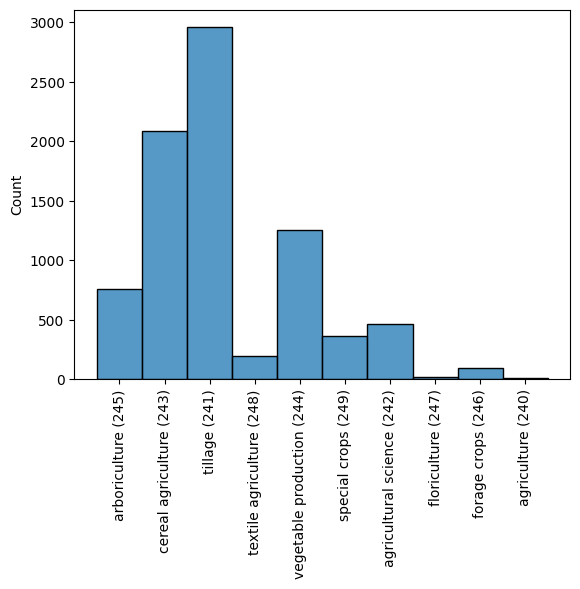

########## 0.7556505803298718


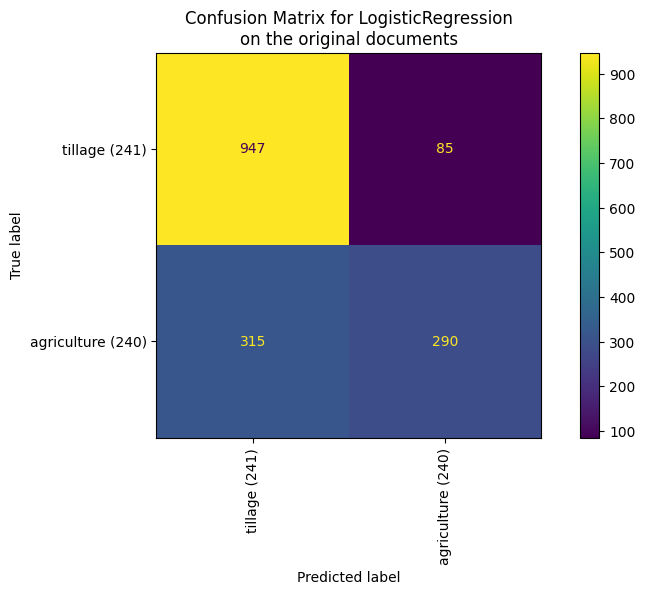

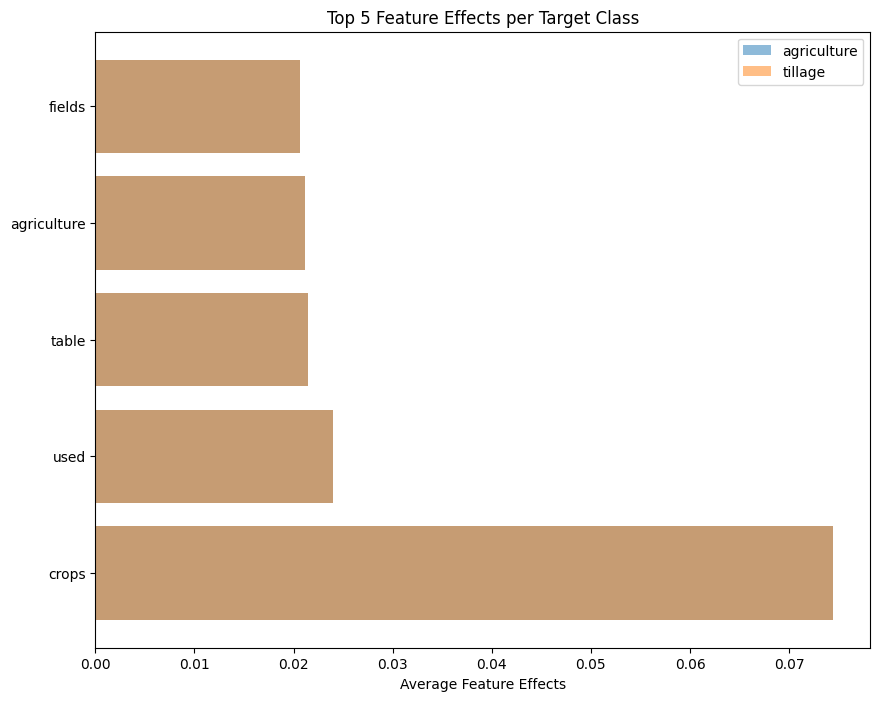

########## 241 RF 

########## Loading data..
True 241 None


C:\Users\alhas\anaconda3\envs\nlp\lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


8183 documents - 3.58MB (training set)
2 categories
vectorize training done in 2.005s at 1.784MB/s
n_samples: 6546, n_features: 6404
n_samples: 1637, n_features: 6404
########## Training RandomForestClassifier



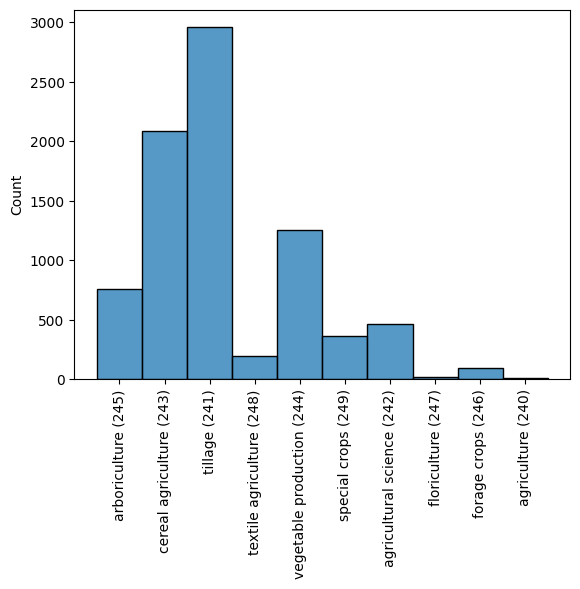

########## 0.744654856444716


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


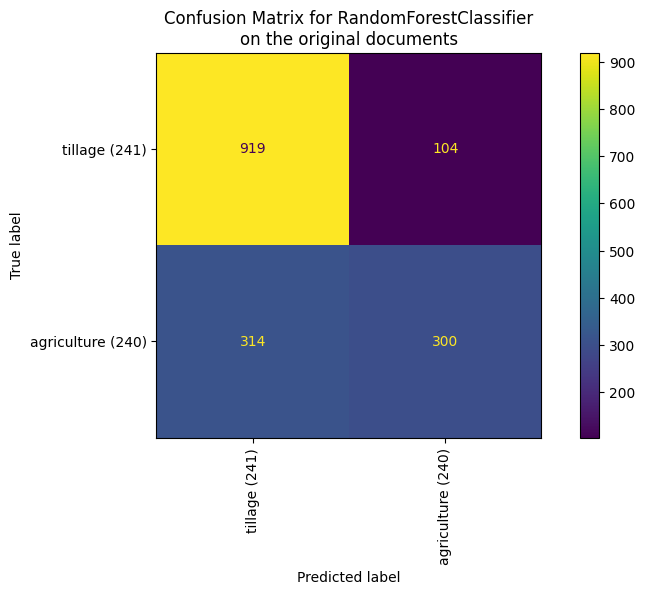

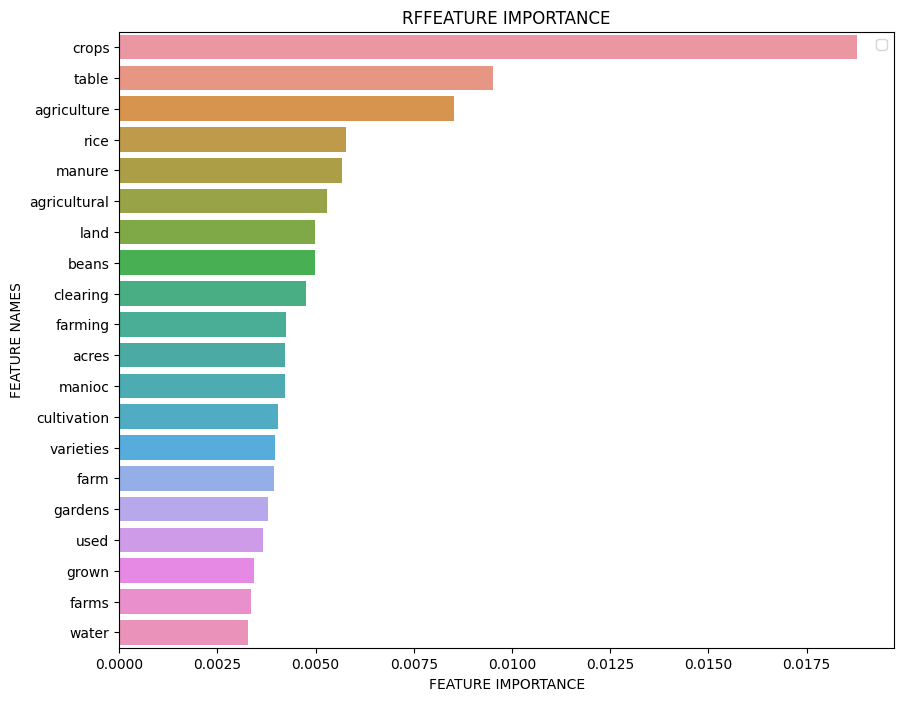

########## 243 LR 

########## Loading data..
True 243 None


C:\Users\alhas\anaconda3\envs\nlp\lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


8183 documents - 3.58MB (training set)
2 categories
vectorize training done in 1.969s at 1.816MB/s
n_samples: 6546, n_features: 6404
n_samples: 1637, n_features: 6404
########## Training LogisticRegression



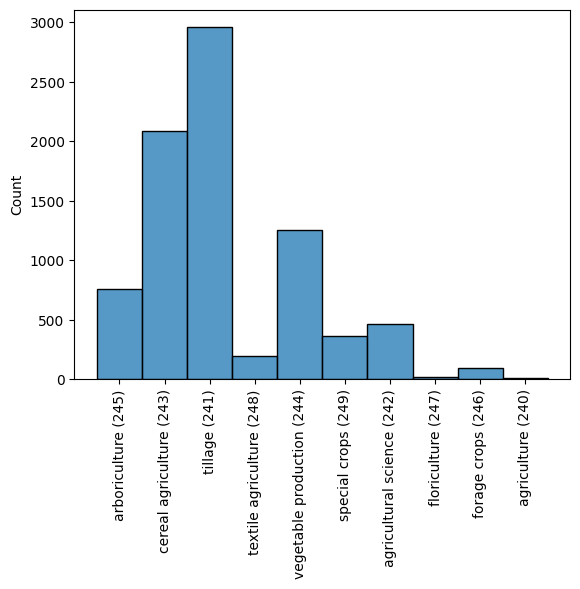

########## 0.8509468540012217


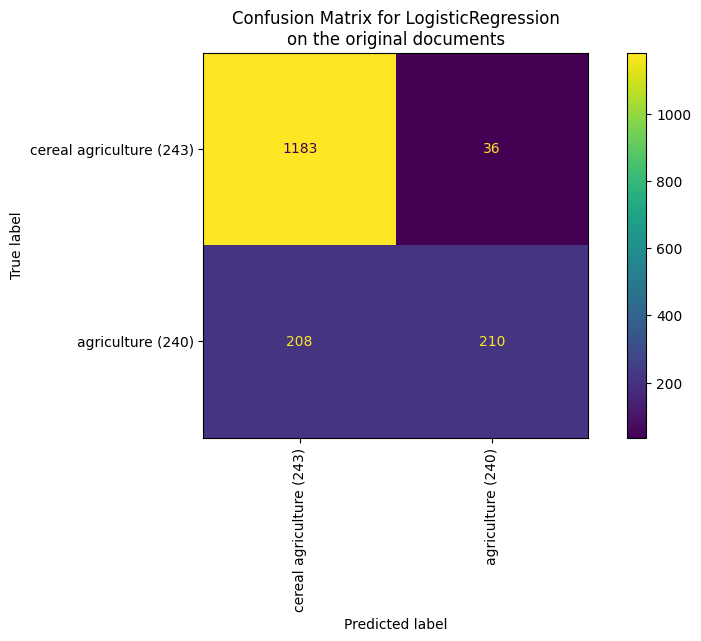

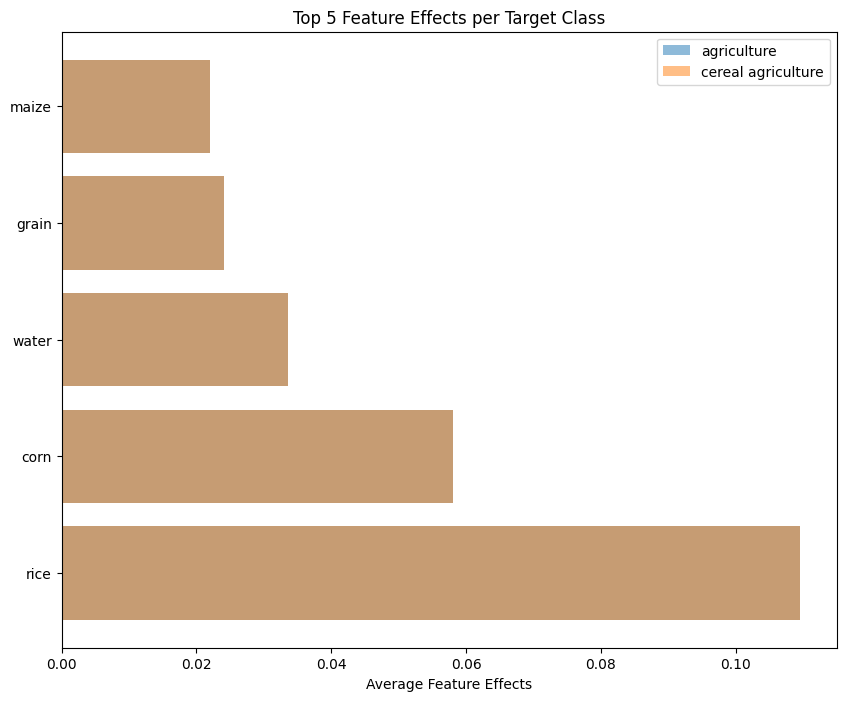

########## 243 RF 

########## Loading data..
True 243 None


C:\Users\alhas\anaconda3\envs\nlp\lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


8183 documents - 3.58MB (training set)
2 categories
vectorize training done in 1.973s at 1.813MB/s
n_samples: 6546, n_features: 6404
n_samples: 1637, n_features: 6404
########## Training RandomForestClassifier



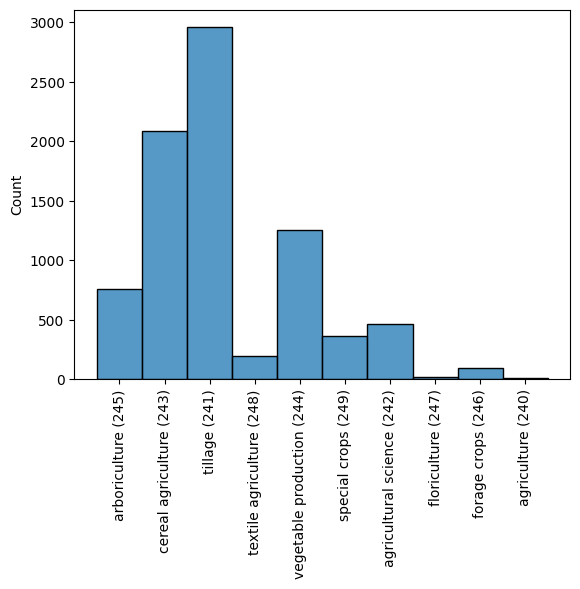

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


########## 0.8662186927306048


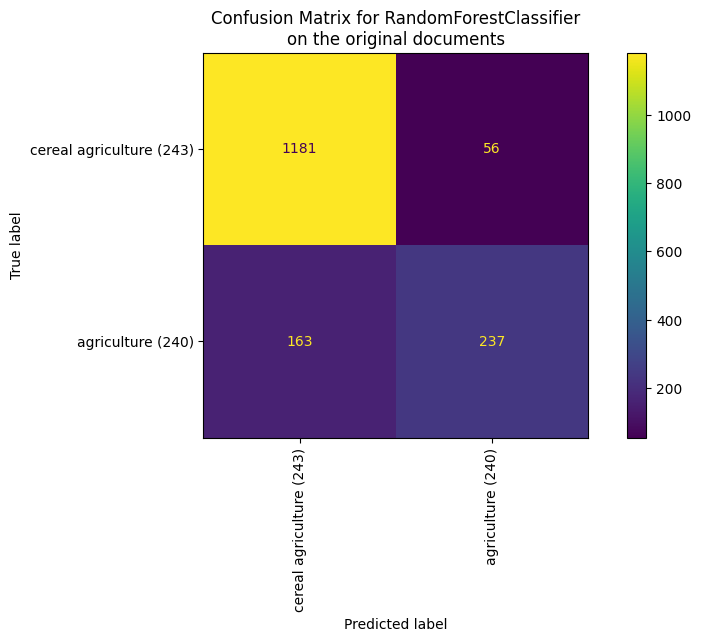

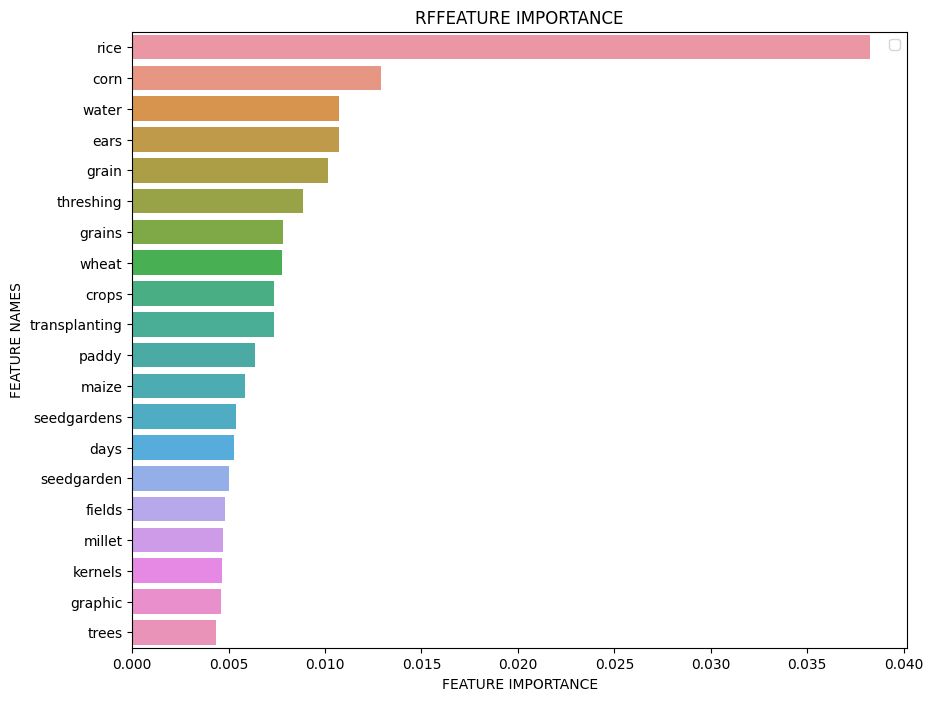

In [8]:
for i in [224, 226, 241, 243]:
    run(models=['LR', 'RF'], cat=i, exact=True)

# Cat vs subcategories (multi-label classification)

########## 224 LR 

########## Loading data..
False 224 None


C:\Users\alhas\anaconda3\envs\nlp\lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


8717 documents - 3.86MB (training set)
9 categories
vectorize training done in 2.159s at 1.788MB/s
n_samples: 6973, n_features: 6825
n_samples: 1744, n_features: 6825
########## Training LogisticRegression



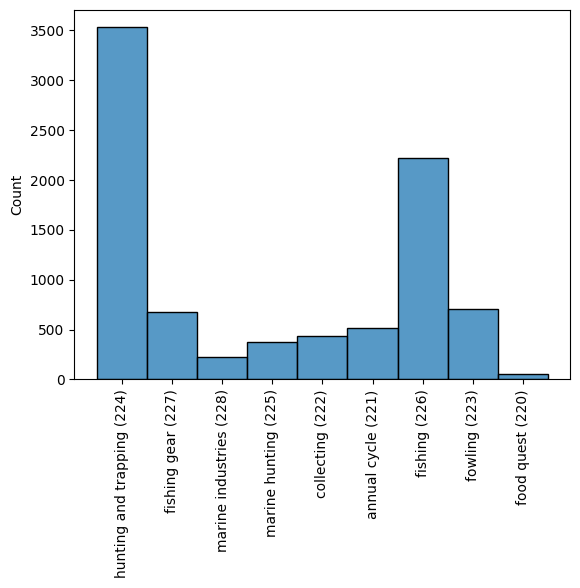

########## 0.7809633027522935


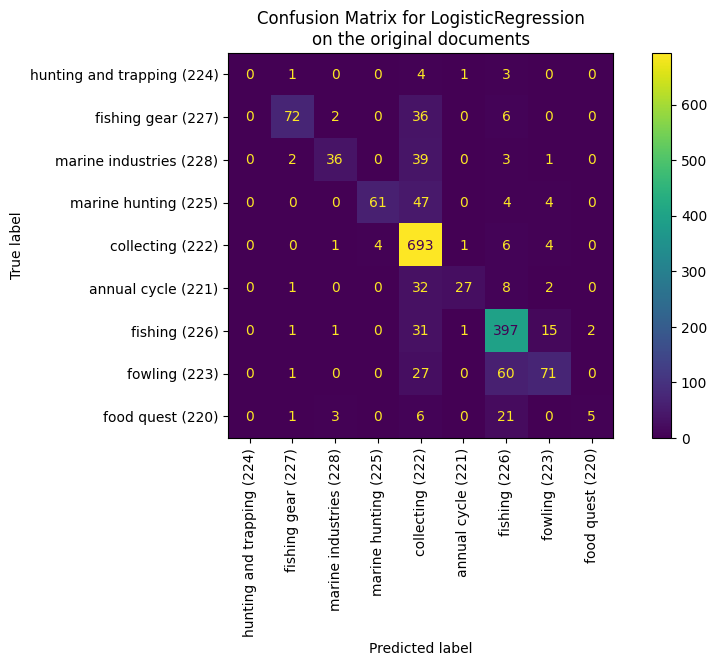

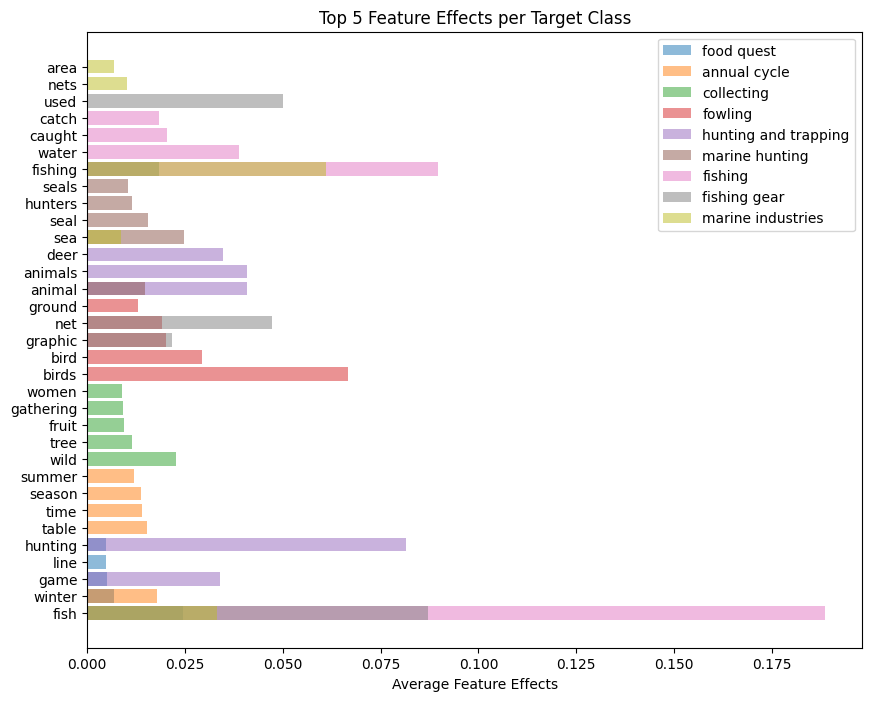

########## 224 RF 

########## Loading data..
False 224 None


C:\Users\alhas\anaconda3\envs\nlp\lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


8717 documents - 3.86MB (training set)
9 categories
vectorize training done in 2.136s at 1.806MB/s
n_samples: 6973, n_features: 6825
n_samples: 1744, n_features: 6825
########## Training RandomForestClassifier



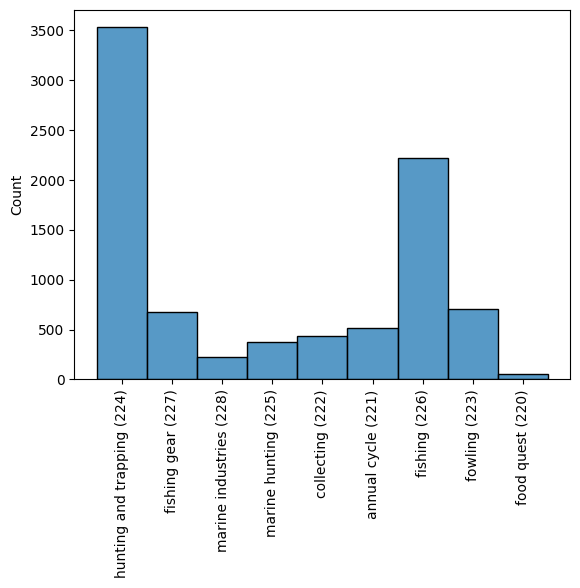

########## 0.7517201834862385


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


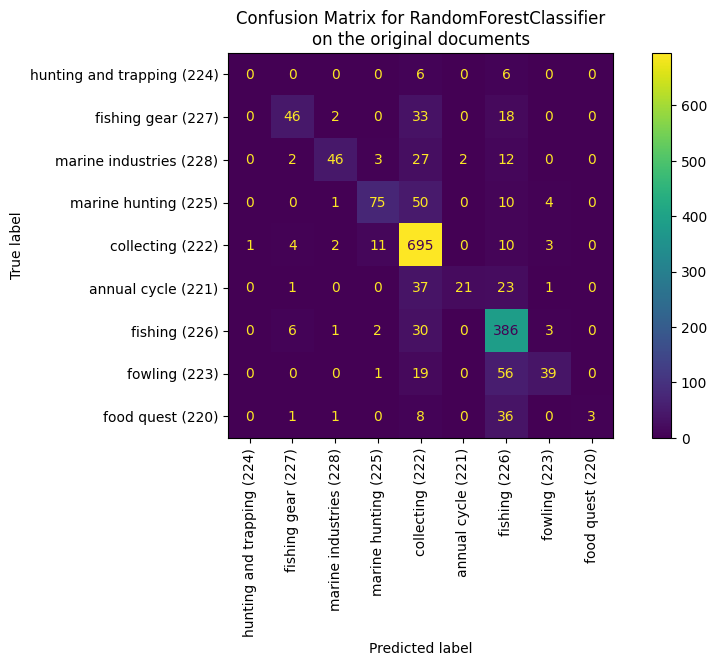

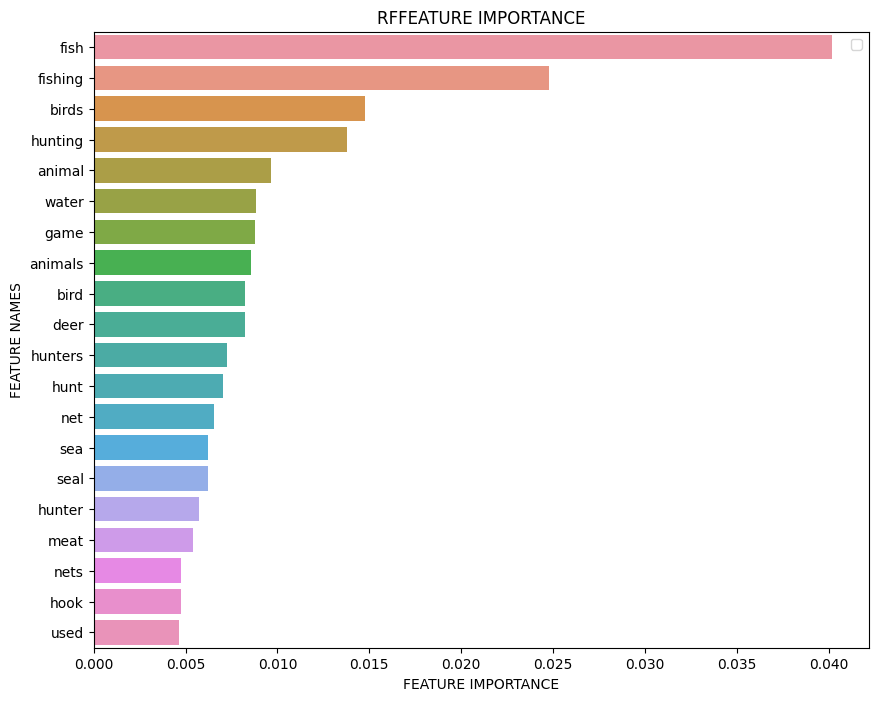

########## 226 LR 

########## Loading data..
False 226 None


C:\Users\alhas\anaconda3\envs\nlp\lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


8717 documents - 3.86MB (training set)
9 categories
vectorize training done in 2.234s at 1.727MB/s
n_samples: 6973, n_features: 6825
n_samples: 1744, n_features: 6825
########## Training LogisticRegression



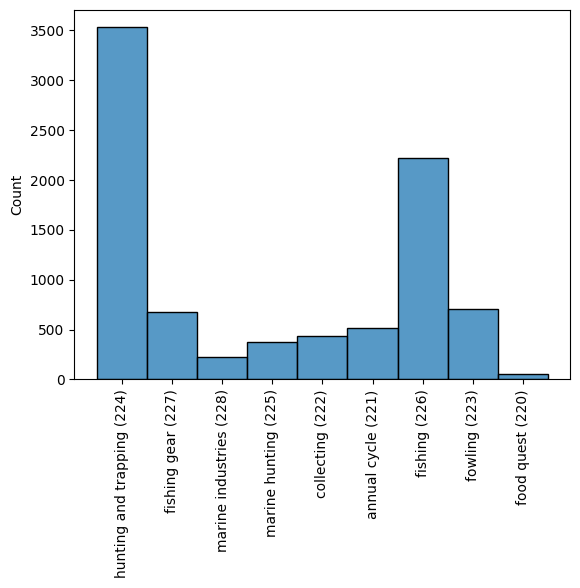

########## 0.7798165137614679


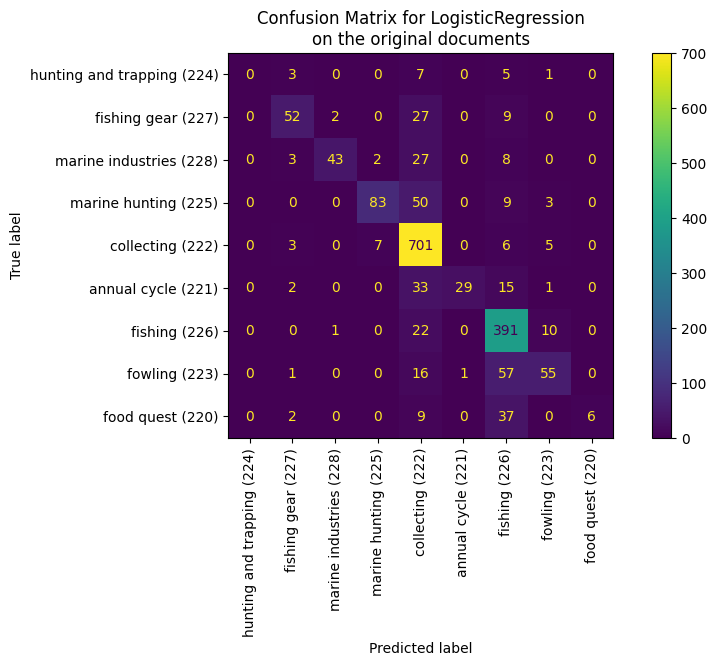

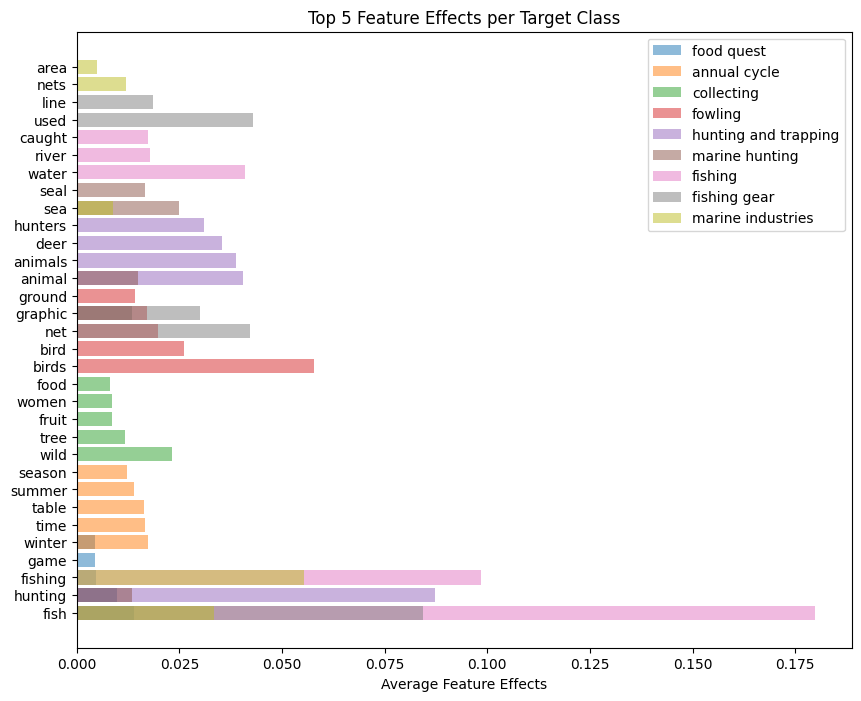

########## 226 RF 

########## Loading data..
False 226 None


C:\Users\alhas\anaconda3\envs\nlp\lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


8717 documents - 3.86MB (training set)
9 categories
vectorize training done in 2.167s at 1.781MB/s
n_samples: 6973, n_features: 6825
n_samples: 1744, n_features: 6825
########## Training RandomForestClassifier



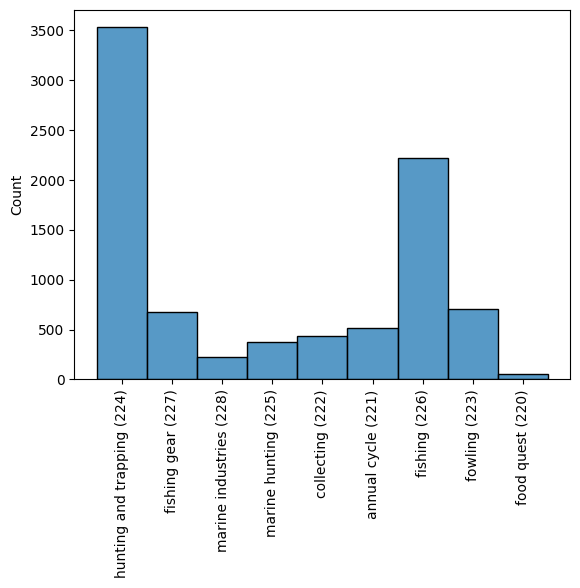

########## 0.7603211009174312


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


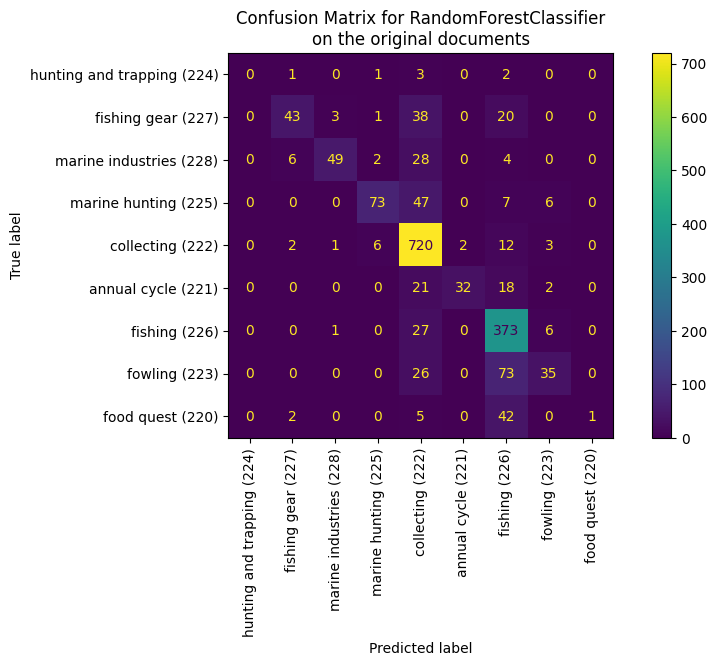

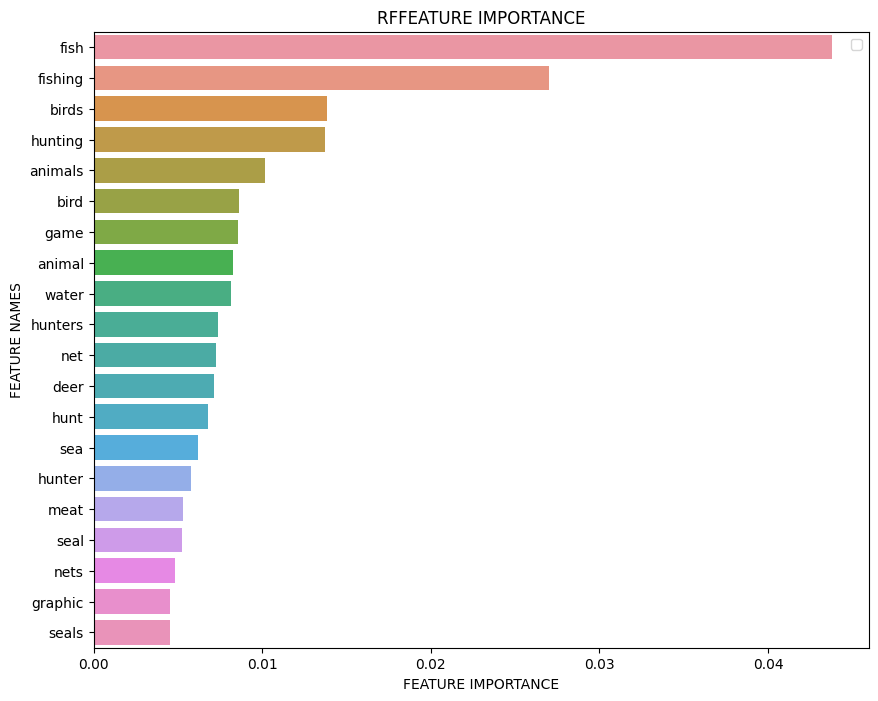

########## 241 LR 

########## Loading data..
False 241 None


C:\Users\alhas\anaconda3\envs\nlp\lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


8183 documents - 3.58MB (training set)
10 categories
vectorize training done in 2.046s at 1.748MB/s
n_samples: 6546, n_features: 6404
n_samples: 1637, n_features: 6404
########## Training LogisticRegression



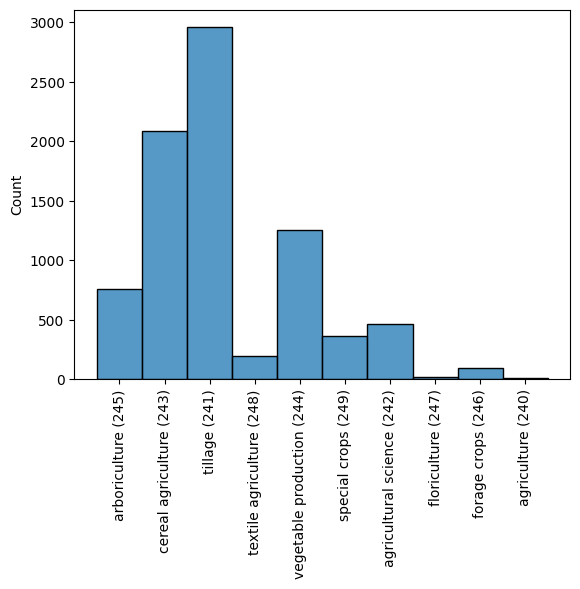

########## 0.6420281001832621


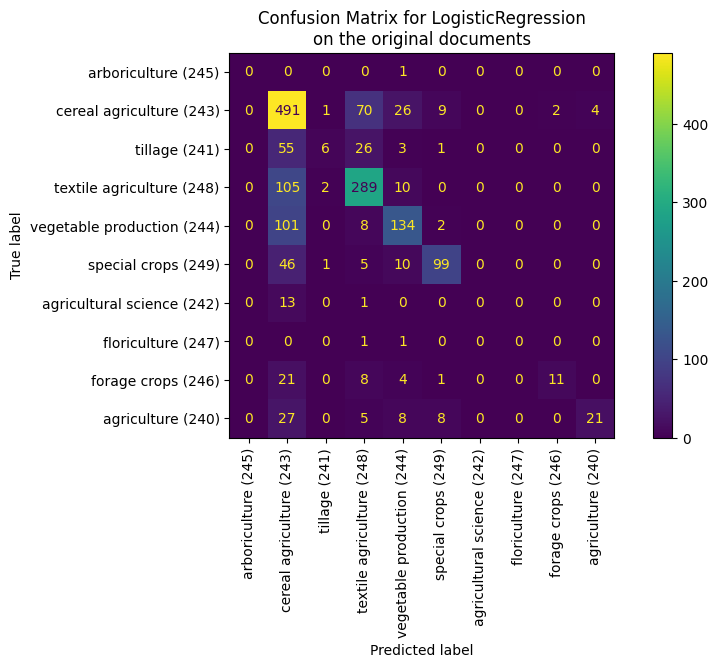

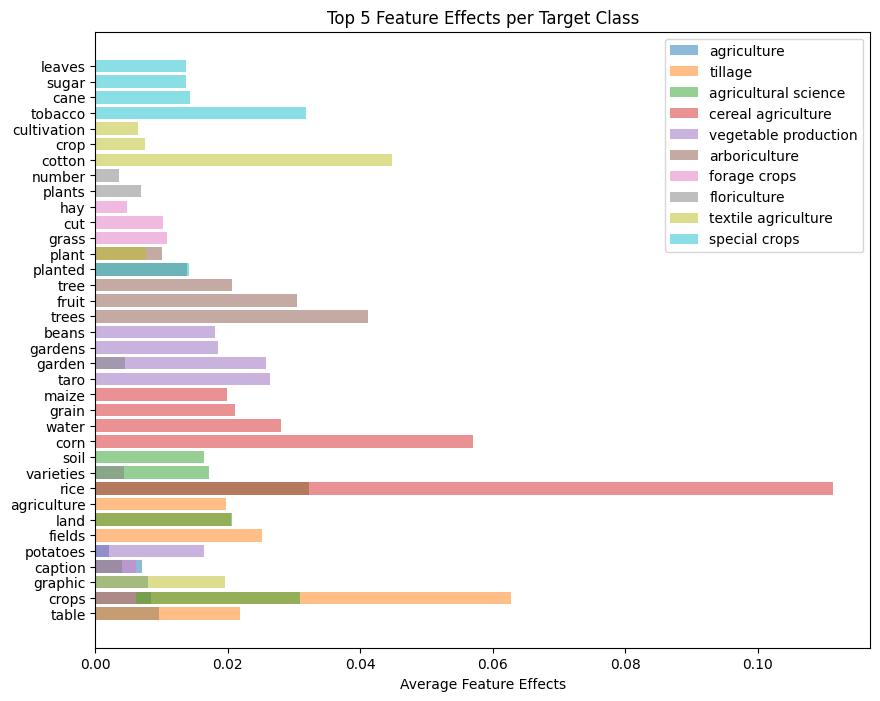

########## 241 RF 

########## Loading data..
False 241 None


C:\Users\alhas\anaconda3\envs\nlp\lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


8183 documents - 3.58MB (training set)
10 categories
vectorize training done in 2.051s at 1.744MB/s
n_samples: 6546, n_features: 6404
n_samples: 1637, n_features: 6404
########## Training RandomForestClassifier



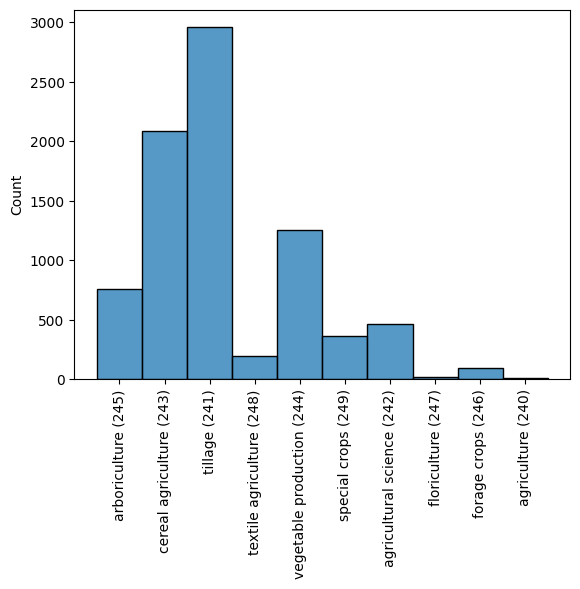

########## 0.643860720830788


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


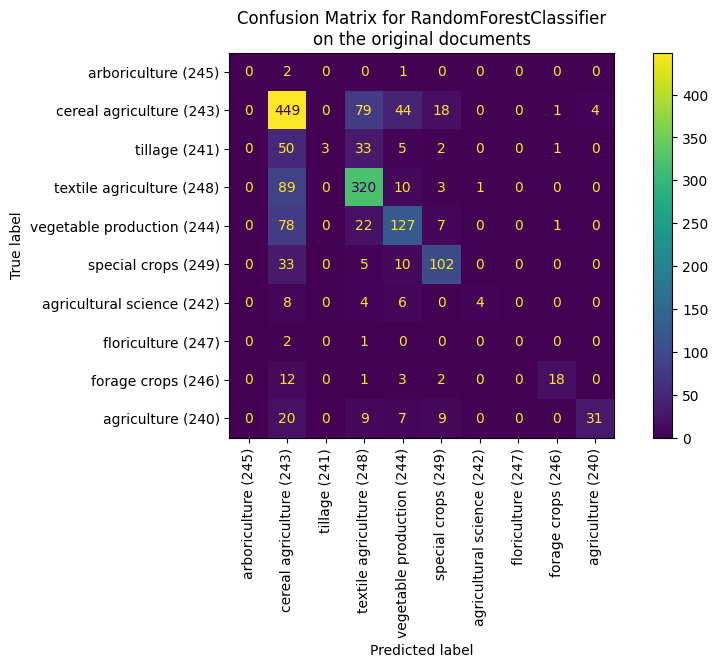

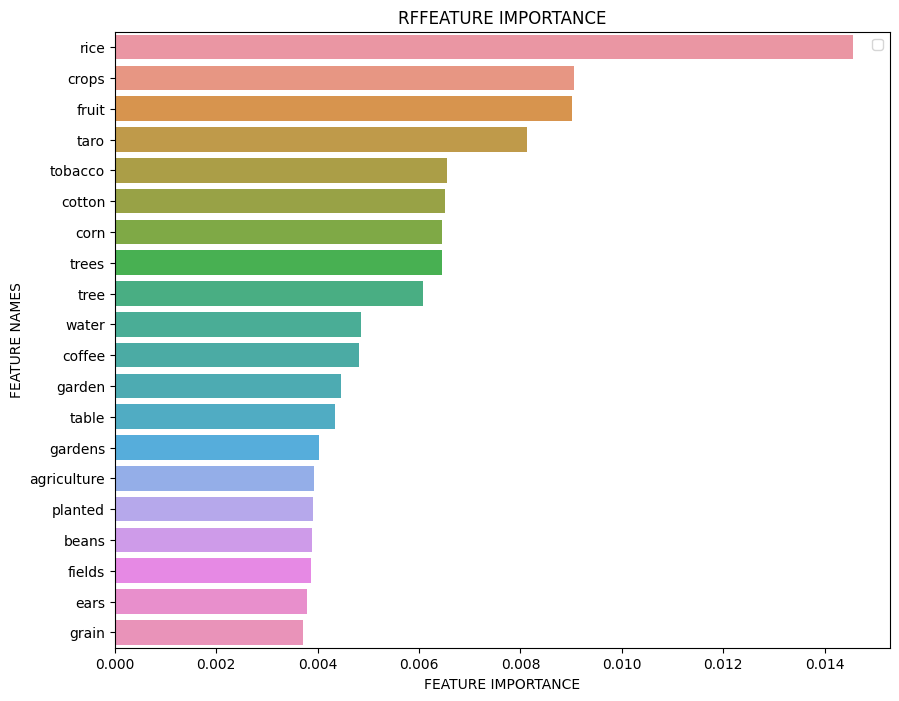

########## 243 LR 

########## Loading data..
False 243 None


C:\Users\alhas\anaconda3\envs\nlp\lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


8183 documents - 3.58MB (training set)
10 categories
vectorize training done in 1.994s at 1.794MB/s
n_samples: 6546, n_features: 6404
n_samples: 1637, n_features: 6404
########## Training LogisticRegression



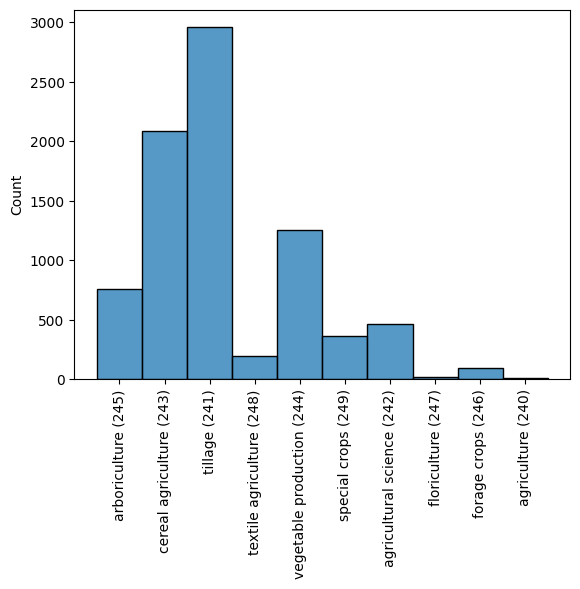

########## 0.6560781918142944


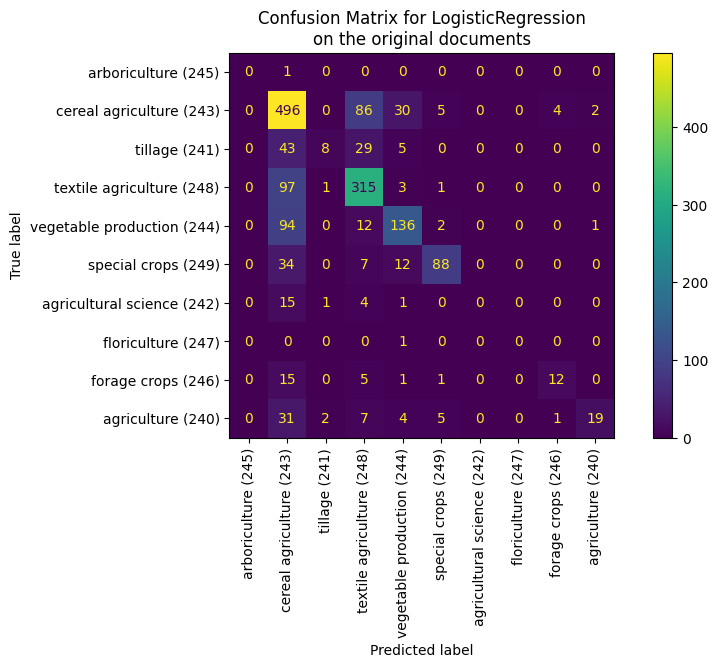

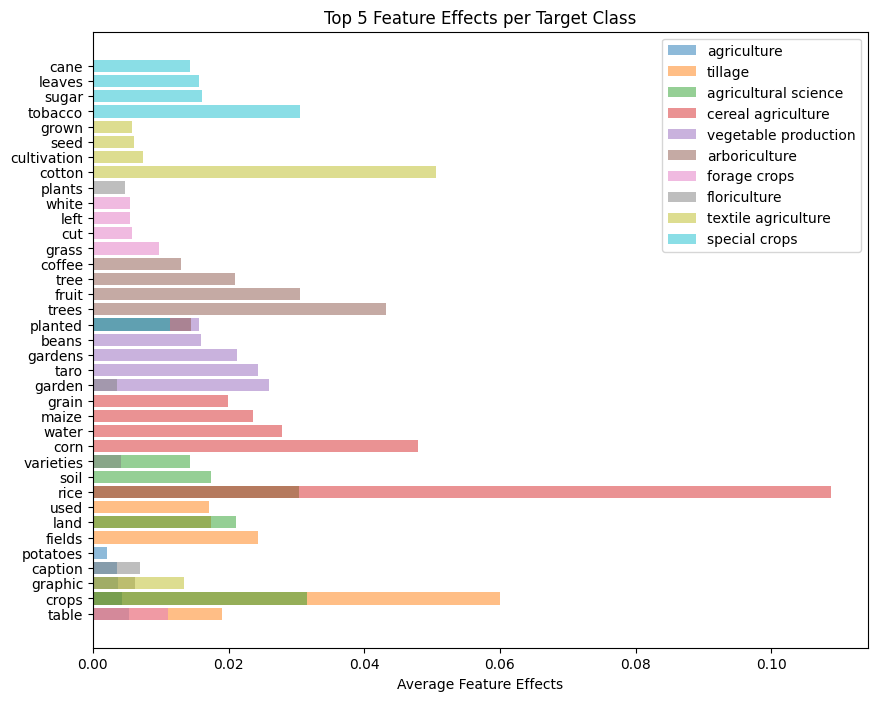

########## 243 RF 

########## Loading data..
False 243 None


C:\Users\alhas\anaconda3\envs\nlp\lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


8183 documents - 3.58MB (training set)
10 categories
vectorize training done in 1.996s at 1.792MB/s
n_samples: 6546, n_features: 6404
n_samples: 1637, n_features: 6404
########## Training RandomForestClassifier



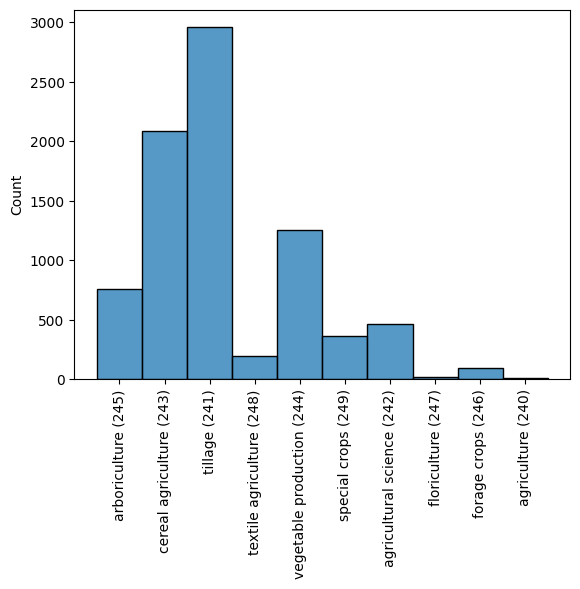

########## 0.6353084911423336


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


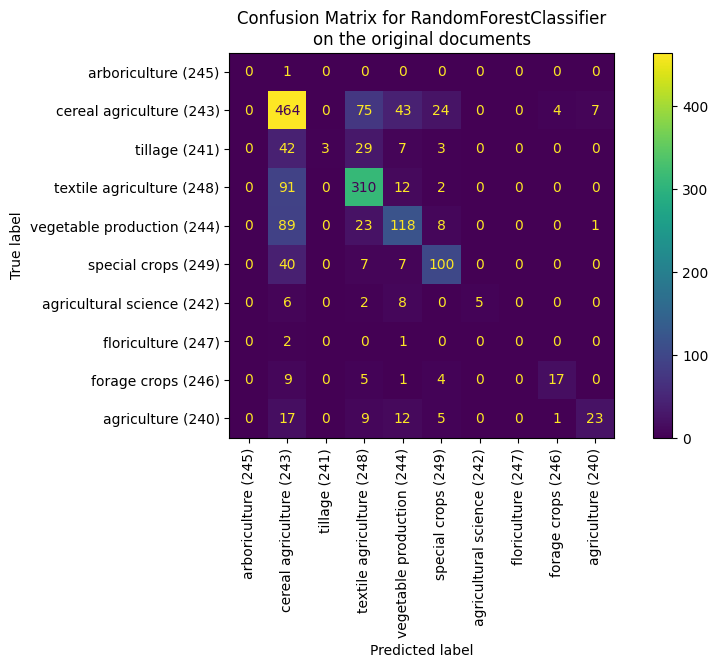

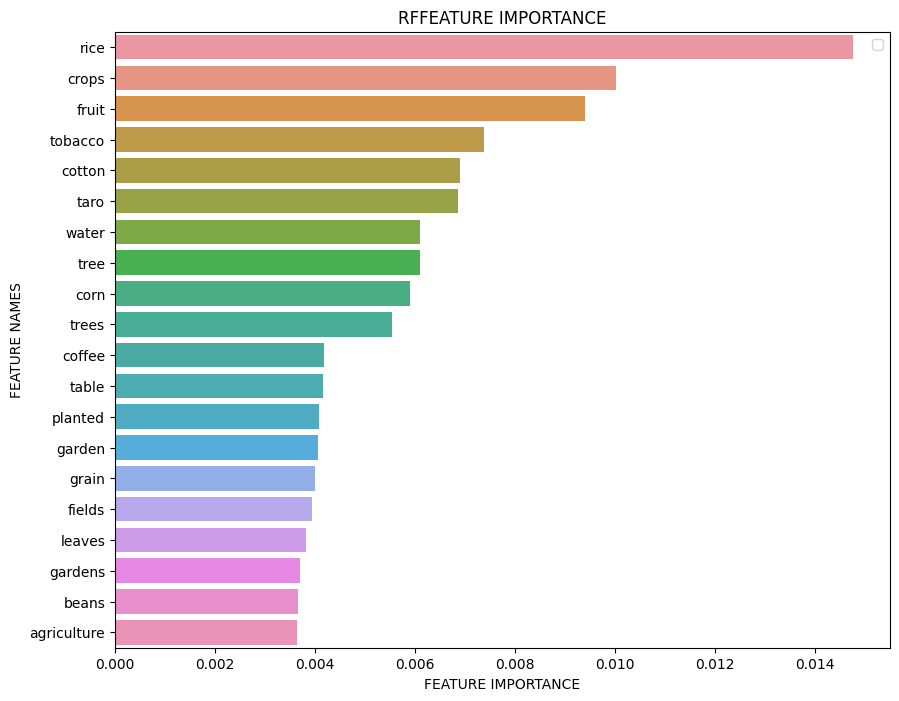

In [9]:
for i in [224, 226, 241, 243]:
    run(models=['LR', 'RF'], cat=i, exact_cat=False)

# Archive

In [24]:
data = []
for i in [224, 226, 241, 243]:
    data.append(df[ df['ocms_list'].map(lambda x: len(x) == 1 and x[0] == i) ])
data = pd.concat(data)

<Axes: xlabel='ocms', ylabel='Count'>

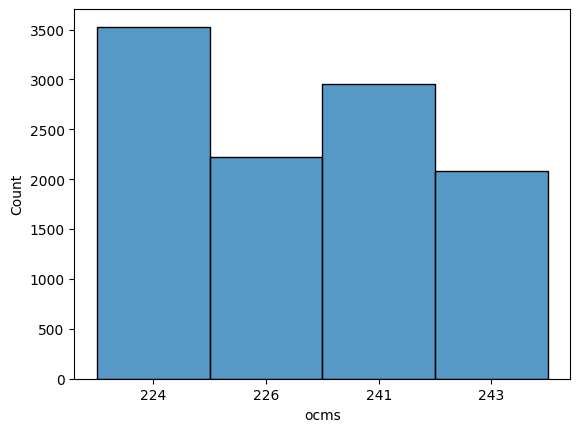

In [33]:
sns.histplot(data['ocms'])
# data.ocms.hist()

In [36]:
s = time.time()

tfidf_vec = TfidfVectorizer(min_df=3, # If a token appears fewer times than this, across all documents, it will be ignored
                             # tokenizer=nltk.word_tokenize, # we use the nltk tokenizer
                             tokenizer=preprocessing.tokenize_data, # we use the custom tokenizer
                             stop_words='english')#stopwords.words('english')) # stopwords are removed

tfidf_text = tfidf_vec.fit_transform(data['textrecord'])


e = time.time()
print("Elapsed time during the whole program in seconds:",
                                         e-s) 

C:\Users\alhas\anaconda3\envs\nlp\lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Elapsed time during the whole program in seconds: 4.240055799484253


## Random Forest

In [87]:
# clf = RandomForestClassifier(random_state=0)
# # cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3)

# param_grid = {"max_depth": [3, None],
#               "min_samples_split": [5, 10],}

# search = HalvingGridSearchCV(clf, param_grid, resource='n_estimators',
#                              max_resources=10,
#                              cv=5,
#                              random_state=0).fit(X_train, y_train)
# search.best_params_  # {'max_depth': None, 'min_samples_split': 10, 'n_estimators': 9}

{'max_depth': None, 'min_samples_split': 10, 'n_estimators': 9}

In [89]:
# search.best_estimator_.score(X_test, y_test)

0.3549950841162333

In [39]:
# Train a Random Forest model
model = RandomForestClassifier(n_estimators=100)
model.fit(X_train, y_train)

RandomForestClassifier()

In [ ]:
# cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3)

# n_scores = cross_val_score(model, 
#                            tfidf_text, data['parent_ocms'], 
#                            scoring='accuracy', 
#                            cv=cv, 
#                            n_jobs=-1, 
#                            error_score='raise')

In [ ]:

# print('Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

In [40]:
# Evaluate the model on the testing set
accuracy = model.score(X_test, y_test)
print("Accuracy:", accuracy)

Accuracy: 0.8364983788791107


In [42]:
preds = model.predict(X_test)
print(preds)

['226' '243' '243' ... '241' '224' '241']


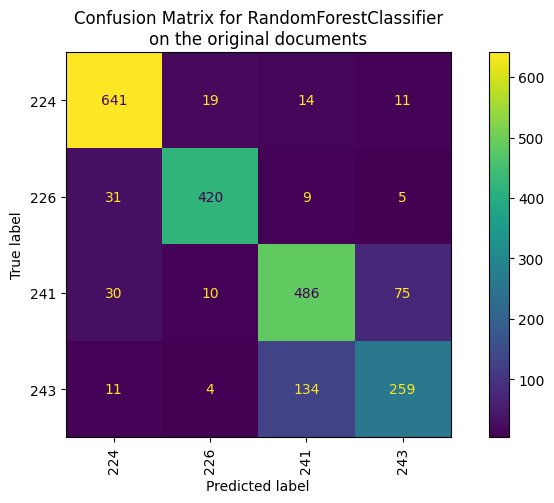

In [43]:
plots.make_cm(model, preds, y_test, data['ocms'].uniqueque())

In [ ]:
report = classification_report(y_test, preds, digits = 3)
print(report)

In [268]:
_test = df['textrecord'][SELECTED*2:SELECTED*3]
_test = text_vec.transform(_test)

In [ ]:
rf.predict(_test)[100:300]

In [ ]:
# Evaluate the model on the testing set
accuracy = rf.score(X_test, y_test)
print("Accuracy:", accuracy)

## Logisitc Regression

In [39]:

pipe = make_pipeline(StandardScaler(with_mean=False), LogisticRegression(max_iter=10000))

In [36]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(tfidf_text, data['parent_ocms'], test_size=0.2)

In [37]:
pipe.fit(X_train, y_train)

/home/hasan/.virtualenvs/thesis/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('standardscaler', StandardScaler(with_mean=False)),
                ('logisticregression',
                 LogisticRegression(C=10, max_iter=1000))])

In [38]:
pipe.score(X_test, y_test)

0.3655

In [27]:
clf.score(X_test, y_test)

0.452

In [27]:
clf.score(X_test, y_test)

0.452

In [ ]:
clf.predict(X[:2, :])

In [ ]:
clf.predict_proba(X[:2, :]).shape

## KNN

In [46]:
k_values = [i for i in range (1,31)]
scores = []

scaler = StandardScaler(with_mean=False)
X = scaler.fit_transform(X_train)

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    score = cross_val_score(knn, X, y_train, cv=5)
    scores.append(np.mean(score))

NameError: name 'plt' is not defined

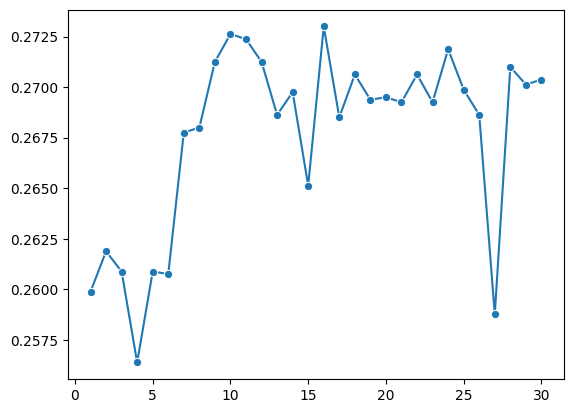

In [48]:
sns.lineplot(x = k_values, y = scores, marker = 'o')
plt.xlabel("K Values")
plt.ylabel("Accuracy Score")

In [7]:
pipe = make_pipeline(StandardScaler(with_mean=False),
                     KNeighborsClassifier(n_neighbors=16))

In [8]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler(with_mean=False)),
                ('kneighborsclassifier', KNeighborsClassifier(n_neighbors=16))])

In [9]:
pipe.score(X_test, y_test)

0.40711009174311924

In [2]:
nlp = spacy.load("en_core_web_sm")

In [13]:
# Define a function to preprocess a text record
def preprocess_text(text):
    doc = nlp(text)
    tokens = [token.lemma_.lower().strip() for token in doc 
              if not token.is_stop and not token.is_punct and token.lemma_ != '-PRON-']
    return tokens

In [14]:
s = time.time()

# Apply the preprocess_text function to the textrecord column
df["processed_text"] = df["textrecord"].apply(preprocess_text)

    
e = time.time()


print("Elapsed time during the whole program in seconds:",
                                         e-s) 

KeyboardInterrupt: 

In [ ]:
df.to_csv('data/splitted_preprocessed.csv')

In [ ]:
s = time.time()

nlp.pipe(df["textrecord"])


e = time.time()


print("Elapsed time during the whole program in seconds:",
                                         e-s) 

In [ ]:
# Preprocess data (e.g., remove missing values, encode categorical variables)

for doc in nlp.pipe(texts):
    # Do something with the doc here
    print([(ent.text, ent.label_) for ent in doc.ents])

    

Elapsed time during the whole program in seconds: 1.9375221729278564


In [ ]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data.drop("dependency_strength", axis=1), data["dependency_strength"], test_size=0.2)

In [ ]:
# Train a Random Forest model
rf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
rf.fit(X_train, y_train)

In [ ]:
# Evaluate the model on the testing set
accuracy = rf.score(X_test, y_test)
print("Accuracy:", accuracy)

# Links
- https://www.datacamp.com/tutorial/random-forests-classifier-python
- https://machinelearningmastery.com/random-forest-ensemble-in-python/
- https://github.com/WillKoehrsen/Data-Analysis/tree/master/random_forest_explained
- https://www.kdnuggets.com/2017/06/7-techniques-handle-imbalanced-data.html
- https://towardsdatascience.com/methods-for-dealing-with-imbalanced-data-5b761be45a18
- **GREAT RESOURCE** https://scikit-learn.org/stable/auto_examples/text/plot_document_classification_20newsgroups.html#sphx-glr-auto-examples-text-plot-document-classification-20newsgroups-py
- https://scikit-learn.org/stable/modules/ensemble.html#subsampling